source: [link text](https://github.com/bnsreenu/python_for_microscopists/blob/master/253_254_cycleGAN_monet2photo/254-cycleGAN_model.py)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

#Imports

In [4]:
!pip install --upgrade keras

In [5]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-z2775rlt
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-z2775rlt
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import PIL
import tensorflow as tf
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.layers import GroupNormalization
# from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

2025-02-16 09:49:29.446850: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-16 09:49:29.456623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-16 09:49:29.468283: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-16 09:49:29.471845: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 09:49:29.480626: I tensorflow/core/platform/cpu_feature_guar

#unzipping the data


In [8]:
# !unzip -u "/content/drive/My Drive/isic/cycle gan/archive.zip" -d "/content/drive/My Drive/isic/cycle gan/dataset"

#merging the data to create 2 categories light and dark

In [10]:
def count_images_in_folder(folder_path):
    all_files = os.listdir(folder_path)
    image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff')
    image_files = [file for file in all_files if file.endswith(image_extensions)]
    return len(image_files)

In [11]:
dataset_path = "./skin cancer/dataset/data_skintone/"

In [12]:
for i in os.listdir(dataset_path):
  print(i, count_images_in_folder(dataset_path + "/" + i))

light 16613
dark 19216
new_path 0


##merging mid-dark with dark category

In [14]:
# import shutil
# for i in os.listdir(dataset_path):
#   if i == "mid-dark":
#     for j in os.listdir(dataset_path + "/" + i):
#       shutil.move(dataset_path + "/" + i + "/" + j, dataset_path + "/dark/" + j)

In [15]:
# os.rmdir(dataset_path + "/" + "mid-dark")

##merging mid-light with light category

In [17]:
# for i in os.listdir(dataset_path):
#   if i == "mid-light":
#     for j in os.listdir(dataset_path + "/" + i):
#       shutil.move(dataset_path + "/" + i + "/" + j, dataset_path + "/light/" + j)

In [18]:
# os.rmdir(dataset_path + "/" + "mid-light")

#preprocessing the images

In [20]:
def load_images(path, count=0,size=(256,256)):
	data_list = list()
	for filename in os.listdir(path):
		if(count>2000):
			break
		count+=1
		pixels = load_img(path + filename, target_size=size)
		pixels = img_to_array(pixels)
		data_list.append(pixels)
	return asarray(data_list)

##loading the images

In [22]:
data_dark = load_images(dataset_path + "/dark/")
data_light = load_images(dataset_path + "/light/")

##plotting the input images

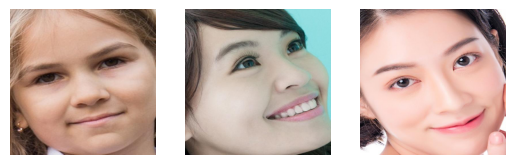

In [24]:
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(data_light[i].astype('uint8'))

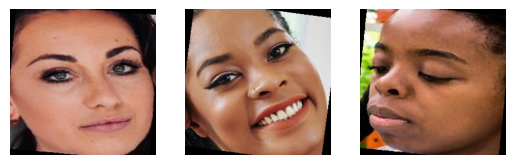

In [25]:
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(data_dark[i].astype('uint8'))
plt.show()

In [26]:
data = [data_light, data_dark]

##converting pixels values to be between -1 and 1

In [28]:
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [29]:
dataset = preprocess_data(data)

In [30]:
dataset[0][0]

array([[[ 0.46666667,  0.31764707,  0.20784314],
        [ 0.5764706 ,  0.42745098,  0.31764707],
        [ 0.6       ,  0.42745098,  0.3254902 ],
        ...,
        [ 0.6313726 ,  0.5372549 ,  0.4117647 ],
        [ 0.62352943,  0.5529412 ,  0.43529412],
        [ 0.5764706 ,  0.5137255 ,  0.4117647 ]],

       [[ 0.49019608,  0.34117648,  0.23137255],
        [ 0.56078434,  0.4117647 ,  0.3019608 ],
        [ 0.58431375,  0.4117647 ,  0.30980393],
        ...,
        [ 0.5921569 ,  0.49019608,  0.3647059 ],
        [ 0.6156863 ,  0.54509807,  0.42745098],
        [ 0.6392157 ,  0.5686275 ,  0.4509804 ]],

       [[ 0.5529412 ,  0.40392157,  0.29411766],
        [ 0.54509807,  0.39607844,  0.28627452],
        [ 0.54509807,  0.37254903,  0.27058825],
        ...,
        [ 0.5764706 ,  0.4509804 ,  0.3254902 ],
        [ 0.6627451 ,  0.56078434,  0.43529412],
        [ 0.7176471 ,  0.62352943,  0.49803922]],

       ...,

       [[ 0.01960784, -0.27058825, -0.41960785],
        [-0

#defining the GAN

##Discriminator
70*70 patchGAN
C64-C128-C256-C512

In [33]:
def define_discriminator(image_shape):
    # weight initialization
    init = tf.keras.initializers.HeNormal()
    # source image input
    in_image = Input(shape=image_shape)
    # C64: 4x4 kernel Stride 2x2
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    # C128: 4x4 kernel Stride 2x2
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = GroupNormalization(groups=-1, axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256: 4x4 kernel Stride 2x2
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = GroupNormalization(groups=-1, axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer : 4x4 kernel but Stride 1x1
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = GroupNormalization(groups=-1, axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    # define model
    model = Model(in_image, patch_out)
    model.trainable=True
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model

##generator
U-net architechture
c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128, u64,c7s1-3

###Defining the resnet blocks for u-net architechture

In [36]:
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = tf.keras.initializers.HeNormal()
	# first convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = GroupNormalization(groups=-1, axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = GroupNormalization(groups=-1, axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g


###U-net

In [38]:
def define_generator(image_shape, n_resnet=9):
    # weight initialization
    init = tf.keras.initializers.HeNormal()
    # image input
    in_image = Input(shape=image_shape)
    # c7s1-64
    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = GroupNormalization(groups=-1, axis=-1)(g)
    g = Activation('relu')(g)
    # d128
    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = GroupNormalization(groups=-1, axis=-1)(g)
    g = Activation('relu')(g)
    # d256
    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = GroupNormalization(groups=-1, axis=-1)(g)
    g = Activation('relu')(g)
    # R256
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    # u128
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = GroupNormalization(groups=-1, axis=-1)(g)
    g = Activation('relu')(g)
    # u64
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = GroupNormalization(groups=-1, axis=-1)(g)
    g = Activation('relu')(g)
    # c7s1-3
    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = GroupNormalization(groups=-1, axis=-1)(g)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    model.trainable=True
    return model

## combined gan model

In [40]:
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    # Make the generator of interest trainable as we will be updating these weights.
    #by keeping other models constant.
    #Remember that we use this same function to train both generators,
    #one generator at a time.
    
    # mark discriminator and second generator as non-trainable
    d_model.trainable = False
    g_model_2.trainable = False
    g_model_1.trainable = True
    
    # adversarial loss
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    # identity loss
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    # cycle loss - forward
    output_f = g_model_2(gen1_out)
    # cycle loss - backward
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    
    # define model graph
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    
    # define the optimizer
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    # compile model with weighting of least squares loss and L1 loss
    
    model.compile(loss=['mse', 'mae', 'mae', 'mae'],
           loss_weights=[1, 5, 10, 10], optimizer=opt)
    d_model.trainable = True
    g_model_2.trainable = True
    return model

# training the GAN

## helper functions

### function to generate real images samples with 1 (True) as label

In [44]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

### function to generate fake images samples with 0 (False) as label

In [46]:
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake images
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

### function to save generator model periodically

In [61]:
save_path = "./skin cancer/dataset/data_skintone/new_path/"
if not os.path.exists(save_path):
    os.mkdir(save_path)
def save_models(step, g_model_AtoB, g_model_BtoA):
	filename1 = f"{save_path}/g_model_AtoB_{step+1:06d}.h5"
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = f"{save_path}/g_model_BtoA_{step+1:06d}.h5"
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

### Function to see output periodically

In [70]:
from matplotlib import pyplot
if not os.path.exists('./skin cancer/generated images'):
    os.mkdir('./skin cancer/generated images')
def summarize_performance(step, g_model, trainX, name, n_samples=5):
    # select a sample of input images
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    # generate translated images
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    # scale all pixels from [-1,1] to [0,1]
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    # plot real images
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_in[i])
        # pyplot.show()
    # plot translated image
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_out[i])
    
    # save plot to file
    filename1 = './skin cancer/generated images/%s_generated_plot_%06d.png' % (name, (step+1))
    pyplot.savefig(filename1)
    pyplot.show()

### function to create an image pool of 50 images

In [73]:
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

### Function to train the GAN

In [76]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1):
	n_epochs, n_batch, = epochs, 1  #batch size fixed to 1 as suggested in the paper
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fake images
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs

	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples from each domain (A and B)
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples using both B to A and A to B generators.
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fake images in the pool. Remember that the paper suggstes a buffer of 50 images
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)

		# update generator B->A via the composite model
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)

        # update generator A->B via the composite model
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

        # summarize performance
        #Since our batch size =1, the number of iterations would be same as the size of our dataset.
        #In one epoch you'd have iterations equal to the number of images.
        #If you have 100 images then 1 epoch would be 100 iterations
		print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance periodically
        #If batch size (total images)=100, performance will be summarized after every 75th iteration.
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 1) == 0:
			# save the models
            # #If batch size (total images)=100, model will be saved after
            #every 75th iteration x 5 = 375 iterations.
			save_models(i, g_model_AtoB, g_model_BtoA)

## Training the GAN on input data

In [79]:
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

I0000 00:00:1739679758.379870    6614 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739679758.533326    6614 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739679758.533485    6614 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739679758.537338    6614 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [81]:
g_model_AtoB.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (GroupNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ group_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     73,856 │ activation[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (GroupNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ group_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │    295,168 │ activation_1[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (GroupNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ group_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    590,080 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (GroupNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ group_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    590,080 │ activation_3[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]    │
│ (GroupNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ group_normalizat… │
│ (Concatenate)       │ 512)              │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │  1,179,904 │ concatenate[0][0

 Total params: 35,276,553 (134.57 MB)

 Trainable params: 35,276,553 (134.57 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
g_model_BtoA.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 256, 256,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_22[0][0]   │
│ (GroupNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 256, 256,  │          0 │ group_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │     73,856 │ activation_15[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_23[0][0]   │
│ (GroupNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 128, 128,  │          0 │ group_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    295,168 │ activation_16[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_24[0][0]   │
│ (GroupNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 64, 64,    │          0 │ group_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │    590,080 │ activation_17[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_25[0][0]   │
│ (GroupNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 64, 64,    │          0 │ group_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 64, 64,    │    590,080 │ activation_18[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_26[0][0]   │
│ (GroupNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 64, 64,    │          0 │ group_normalizat… │
│ (Concatenate)       │ 512)              │            │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 64, 64,    │  1,179,904 │ concatenate_9[0]

 Total params: 35,276,553 (134.57 MB)

 Trainable params: 35,276,553 (134.57 MB)

 Non-trainable params: 0 (0.00 B)

In [85]:
d_model_A.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_48          │ (None, 64, 64, 128)    │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_49          │ (None, 32, 32, 256)    │           512 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 32, 32, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_50          │ (None, 32, 32, 512)    │         1,024 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 32, 32, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,766,529 (10.55 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
d_model_B.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_51          │ (None, 64, 64, 128)    │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_52          │ (None, 32, 32, 256)    │           512 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 32, 32, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_53          │ (None, 32, 32, 512)    │         1,024 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 32, 32, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,766,529 (10.55 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
c_model_AtoB.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 256, 256,  │ 35,276,553 │ input_layer_4[0]… │
│ (Functional)        │ 3)                │            │ input_layer_5[0]… │
│                     │                   │            │ functional_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 256, 256,  │ 35,276,553 │ functional[0][0], │
│ (Functional)        │ 3)                │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 32, 32, 1) │  2,766,529 │ functional[0][0]  │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 73,319,635 (279.69 MB)

 Trainable params: 73,319,635 (279.69 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
c_model_BtoA.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 256, 256,  │ 35,276,553 │ input_layer_6[0]… │
│ (Functional)        │ 3)                │            │ input_layer_7[0]… │
│                     │                   │            │ functional[4][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 256, 256,  │ 35,276,553 │ functional_1[2][… │
│ (Functional)        │ 3)                │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 32, 32, 1) │  2,766,529 │ functional_1[2][… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 73,319,635 (279.69 MB)

 Trainable params: 73,319,635 (279.69 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Iteration>11523, dA[0.164,0.164] dB[0.180,0.180] g[3.277,3.666]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>11524, dA[0.164,0.164] dB[0.180,0.180] g[3.277,3.666]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>11525, dA[0.164,0.164] dB[0.180,0.180] g[3.277,3.666]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Iteration>11526, dA[0.164,0.164] dB[0.180,0.180] g[3.277,3.666]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>11527, dA[0.164,0.164] dB[0.180,0.180] g[3.277,3.666]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>11528, dA[0.164,0.164] dB[0.180,0.180] g[3.277,3.666]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>11529, dA[0.164,0.164] dB[0.180,0.180] g[3.277,3.666]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━

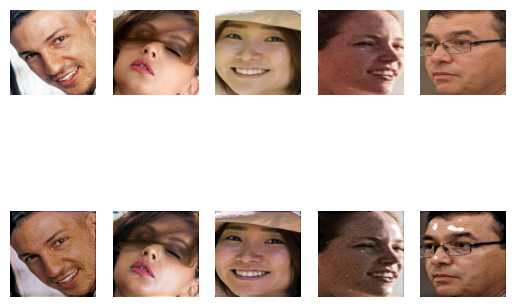

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


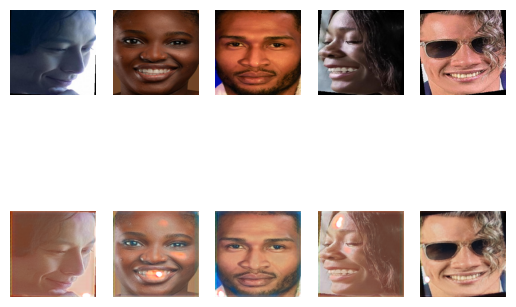

>Saved: ./skin cancer/dataset/data_skintone/new_path//g_model_AtoB_012006.h5 and ./skin cancer/dataset/data_skintone/new_path//g_model_BtoA_012006.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Iteration>12007, dA[0.164,0.164] dB[0.181,0.181] g[3.248,3.638]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Iteration>12008, dA[0.164,0.164] dB[0.181,0.181] g[3.248,3.638]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Iteration>12009, dA[0.164,0.164] dB[0.181,0.181] g[3.248,3.638]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Iteration>12010, dA[0.164,0.164] dB[0.181,0.181] g[3.247,3.638]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Iteration>12011, dA[0.164,0.164] dB[0.181,0.181] g[3.247,3.638]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Iteration>12012, dA[0.164,0.164] dB[0.181,0.181] g[3.247,3.638]
1/1 ━━━━━━

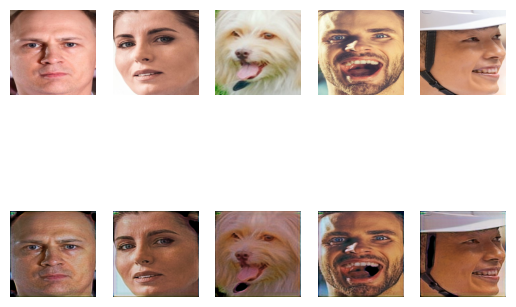

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


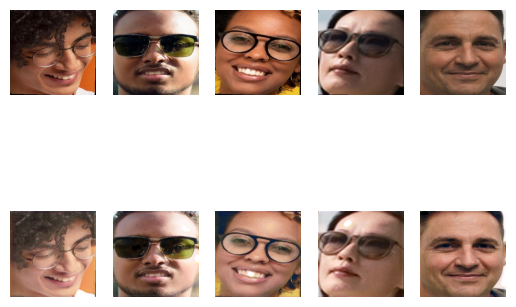

>Saved: ./skin cancer/dataset/data_skintone/new_path//g_model_AtoB_014007.h5 and ./skin cancer/dataset/data_skintone/new_path//g_model_BtoA_014007.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Iteration>14008, dA[0.166,0.166] dB[0.182,0.182] g[3.132,3.524]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>14009, dA[0.166,0.166] dB[0.182,0.182] g[3.132,3.524]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Iteration>14010, dA[0.166,0.166] dB[0.182,0.182] g[3.132,3.524]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Iteration>14011, dA[0.166,0.166] dB[0.182,0.182] g[3.132,3.524]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Iteration>14012, dA[0.166,0.166] dB[0.182,0.182] g[3.132,3.524]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Iteration>14013, dA[0.166,0.166] dB[0.182,0.182] g[3.132,3.524]
1/1 ━━━━━━

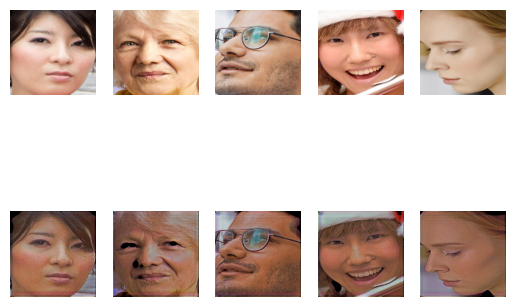

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


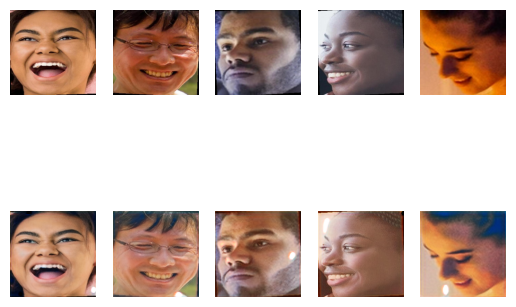

>Saved: ./skin cancer/dataset/data_skintone/new_path//g_model_AtoB_016008.h5 and ./skin cancer/dataset/data_skintone/new_path//g_model_BtoA_016008.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>16009, dA[0.170,0.170] dB[0.183,0.183] g[3.040,3.424]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Iteration>16010, dA[0.170,0.170] dB[0.183,0.183] g[3.040,3.424]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>16011, dA[0.170,0.170] dB[0.183,0.183] g[3.040,3.424]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Iteration>16012, dA[0.170,0.170] dB[0.183,0.183] g[3.040,3.424]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Iteration>16013, dA[0.170,0.170] dB[0.183,0.183] g[3.040,3.424]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Iteration>16014, dA[0.170,0.170] dB[0.183,0.183] g[3.040,3.424]
1/1 ━━━━━━

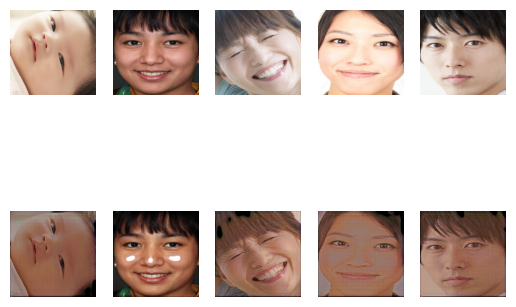

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


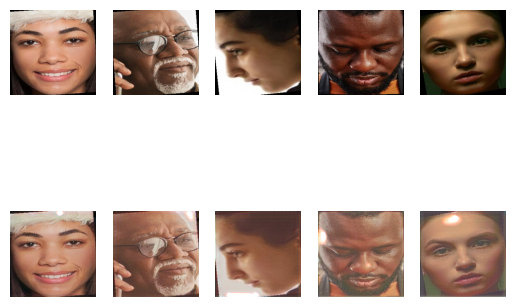

>Saved: ./skin cancer/dataset/data_skintone/new_path//g_model_AtoB_018009.h5 and ./skin cancer/dataset/data_skintone/new_path//g_model_BtoA_018009.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>18010, dA[0.174,0.174] dB[0.186,0.186] g[2.963,3.336]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>18011, dA[0.174,0.174] dB[0.186,0.186] g[2.963,3.336]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>18012, dA[0.174,0.174] dB[0.186,0.186] g[2.963,3.336]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Iteration>18013, dA[0.174,0.174] dB[0.186,0.186] g[2.963,3.336]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>18014, dA[0.174,0.174] dB[0.186,0.186] g[2.963,3.336]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Iteration>18015, dA[0.174,0.174] dB[0.186,0.186] g[2.963,3.336]
1/1 ━━━━━━

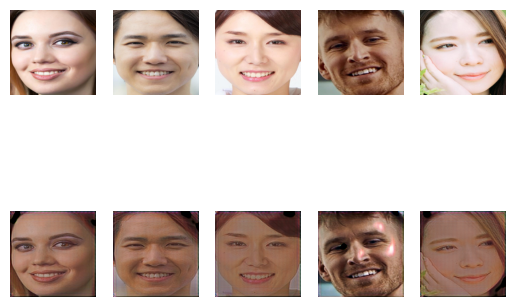

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


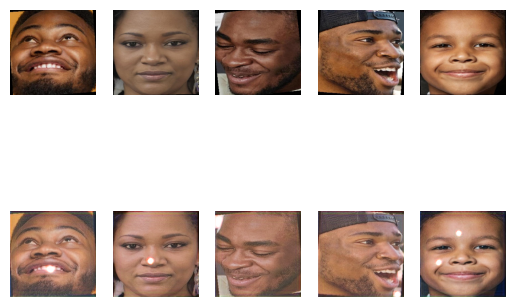

>Saved: ./skin cancer/dataset/data_skintone/new_path//g_model_AtoB_020010.h5 and ./skin cancer/dataset/data_skintone/new_path//g_model_BtoA_020010.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Iteration>20011, dA[0.180,0.180] dB[0.190,0.190] g[2.897,3.262]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Iteration>20012, dA[0.180,0.180] dB[0.190,0.190] g[2.897,3.262]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Iteration>20013, dA[0.180,0.180] dB[0.190,0.190] g[2.897,3.262]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>20014, dA[0.180,0.180] dB[0.190,0.190] g[2.897,3.262]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>20015, dA[0.180,0.180] dB[0.190,0.190] g[2.897,3.262]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>20016, dA[0.180,0.180] dB[0.190,0.190] g[2.897,3.262]
1/1 ━━━━━━

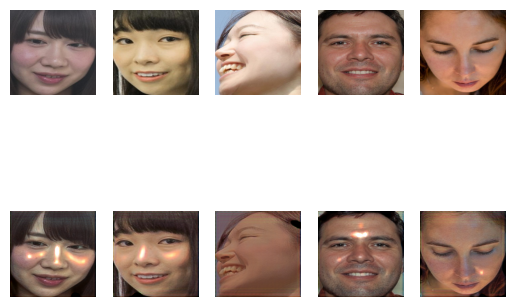

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


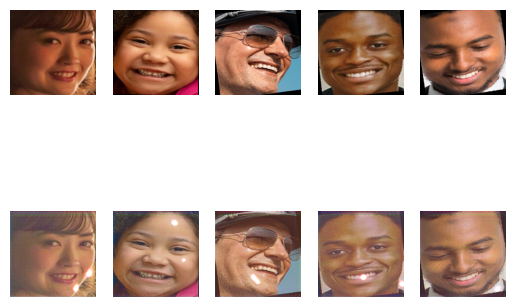

>Saved: ./skin cancer/dataset/data_skintone/new_path//g_model_AtoB_022011.h5 and ./skin cancer/dataset/data_skintone/new_path//g_model_BtoA_022011.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Iteration>22012, dA[0.186,0.186] dB[0.195,0.195] g[2.845,3.213]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>22013, dA[0.186,0.186] dB[0.195,0.195] g[2.845,3.212]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Iteration>22014, dA[0.186,0.186] dB[0.195,0.195] g[2.845,3.212]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>22015, dA[0.186,0.186] dB[0.195,0.195] g[2.845,3.212]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Iteration>22016, dA[0.186,0.186] dB[0.195,0.195] g[2.845,3.212]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>22017, dA[0.186,0.186] dB[0.195,0.195] g[2.845,3.212]
1/1 ━━━━━━

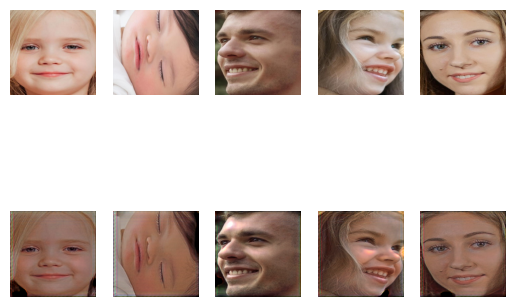

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


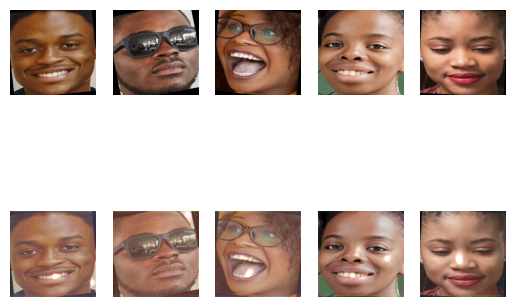

>Saved: ./skin cancer/dataset/data_skintone/new_path//g_model_AtoB_024012.h5 and ./skin cancer/dataset/data_skintone/new_path//g_model_BtoA_024012.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>24013, dA[0.194,0.194] dB[0.199,0.199] g[2.805,3.174]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Iteration>24014, dA[0.194,0.194] dB[0.199,0.199] g[2.805,3.174]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Iteration>24015, dA[0.194,0.194] dB[0.199,0.199] g[2.805,3.174]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Iteration>24016, dA[0.194,0.194] dB[0.199,0.199] g[2.805,3.174]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>24017, dA[0.194,0.194] dB[0.199,0.199] g[2.805,3.174]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Iteration>24018, dA[0.194,0.194] dB[0.199,0.199] g[2.804,3.174]
1/1 ━━━━━━

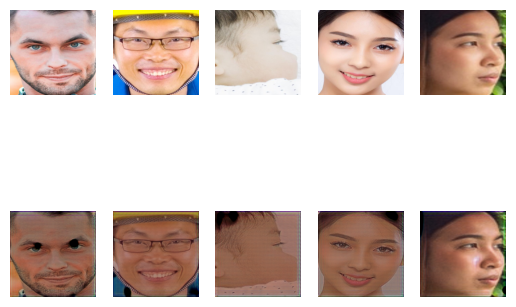

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


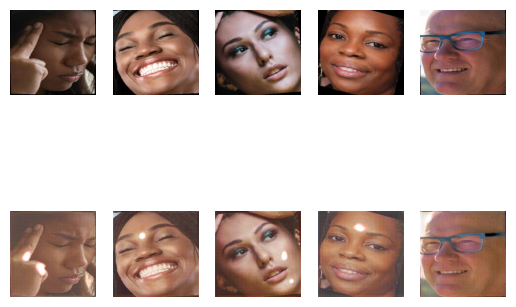

>Saved: ./skin cancer/dataset/data_skintone/new_path//g_model_AtoB_030015.h5 and ./skin cancer/dataset/data_skintone/new_path//g_model_BtoA_030015.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Iteration>30016, dA[0.226,0.226] dB[0.212,0.212] g[2.713,3.130]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>30017, dA[0.226,0.226] dB[0.212,0.212] g[2.713,3.130]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>30018, dA[0.226,0.226] dB[0.212,0.212] g[2.713,3.130]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Iteration>30019, dA[0.226,0.226] dB[0.212,0.212] g[2.713,3.130]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Iteration>30020, dA[0.226,0.226] dB[0.212,0.212] g[2.713,3.130]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Iteration>30021, dA[0.226,0.226] dB[0.212,0.212] g[2.713,3.130]
1/1 ━━━━━━

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Iteration>31940, dA[0.236,0.236] dB[0.219,0.219] g[2.691,3.114]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Iteration>31941, dA[0.236,0.236] dB[0.219,0.219] g[2.691,3.114]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Iteration>31942, dA[0.236,0.236] dB[0.219,0.219] g[2.691,3.114]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Iteration>31943, dA[0.236,0.236] dB[0.219,0.219] g[2.691,3.114]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Iteration>31944, dA[0.236,0.236] dB[0.219,0.219] g[2.691,3.114]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Iteration>31945, dA[0.236,0.236] dB[0.219,0.219] g[2.691,3.114]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Iteration>31946, dA[0.236,0.236] dB[0.219,0.219] g[2.691,3.113]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Iteration>31947, dA[

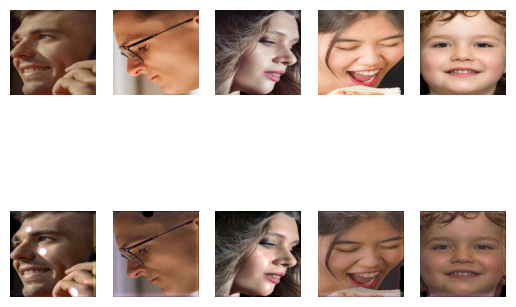

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


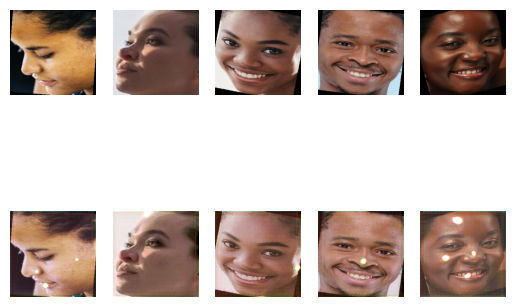

>Saved: ./skin cancer/dataset/data_skintone/new_path//g_model_AtoB_034017.h5 and ./skin cancer/dataset/data_skintone/new_path//g_model_BtoA_034017.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Iteration>34018, dA[0.246,0.246] dB[0.228,0.228] g[2.681,3.108]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Iteration>34019, dA[0.246,0.246] dB[0.228,0.228] g[2.681,3.108]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Iteration>34020, dA[0.246,0.246] dB[0.228,0.228] g[2.681,3.108]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Iteration>34021, dA[0.246,0.246] dB[0.228,0.228] g[2.681,3.108]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Iteration>34022, dA[0.246,0.246] dB[0.228,0.228] g[2.681,3.108]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Iteration>34023, dA[0.246,0.246] dB[0.228,0.228] g[2.681,3.108]
1/1 ━━━━━━

KeyboardInterrupt: 

In [93]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=100)

In [101]:
def convert_img_to_neg1_to_1(dataset):
  img_list = []
  for img in dataset:
    img = ((img / 127.5) - 1)
    img_list.append(img)

  return img_list

In [103]:
def create_images(g_model_AtoB, dataset):
  dark_image_list = []
  for image in dataset:
    dark_image = g_model_AtoB.predict(image)
    dark_image_list.append(dark_image)
    return dark_image_list

In [105]:
def convert_images_to_0_to_255(image_list):
  image_list_0_to_255 = []
  for image in image_list:
    image = ((image + 1) / 2) * 255
    image_list_0_to_255.append(image)
  return image_list